# 1. Basic workflow


This vignette shows the basic workflow of Via and how to access the different visualizations after running the computations. The dataset is a toy multifurcation.
We start by importing modules. 
the examples import is only required if running the function main_Toy() which wraps the workflow demonstrated below

In [16]:
#from examples import *
from pyVIA.core import *
import pandas as pd 
import umap 
import scanpy as sc

In [ ]:
#Wrapper function that includes the various step-by-step blocks shown below 
#The wrapper shows the various types of outputs to be expected and can check your installation 
#Use the more detailed subsequent blocks of code to see how to run VIA 
#main_Toy(ncomps=30, knn=20, random_seed=41, dataset='Toy3', foldername="/home/shobi/Trajectory/Datasets/Toy3/")

First load all the data and make an anndata object. Umap is also used to create a 2D embedding used for visualization. Umap can be substituted with tsne/phate/PCA etc

In [3]:
foldername="/home/shobi/Trajectory/Datasets/Toy3/" #folder where your datafiles are saved
df_counts = pd.read_csv(foldername + "toy_multifurcating_M8_n1000d1000.csv", delimiter=",")
df_ids = pd.read_csv(foldername + "toy_multifurcating_M8_n1000d1000_ids_with_truetime.csv", delimiter=",")

#define parameters

ncomps, knn, random_seed, dataset, root_user  =30,20, 41,'toy', ['M1']

#get the cell IDs and sort them to match the order or cell IDs in the df_counts file
df_ids['cell_id_num'] = [int(s[1::]) for s in df_ids['cell_id']]
df_counts = df_counts.drop('Unnamed: 0', 1)
df_ids = df_ids.sort_values(by=['cell_id_num'])
df_ids = df_ids.reset_index(drop=True)
true_label = df_ids['group_id'].tolist()

#make anndata object with counts and group_ids 
adata_counts = sc.AnnData(df_counts, obs=df_ids)
sc.tl.pca(adata_counts, svd_solver='arpack', n_comps=ncomps)

embedding = umap.UMAP().fit_transform(adata_counts.obsm['X_pca'][:, 0:10])

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


graph.data.size 19066
graph.data.size 19058 19058


### Expected Outputs
1. Cluster graph level trajectory highlighting cell type composition, pseudotime and start/end states 
2. Trajectory drawn onto UMAP embedding.
3. Lineage pathways depicting lineage probabilities towards each of the detected terminal states
4. Gene trends for each lineage for marker genes
5. Vector fields for fine-grained trajectory
6. Cluster graph trajectory colored by gene expression level

In this vignette we run VIA in two iterations. The first is a coarse-grained iteration with larger clusters and this is useful for limiting the number of proposed terminal states. The second iteration offers a more granular view and uses the terminal states detected in the coarse grained run. 

However, it is perfectly fine to run VIA on just a single iteration set at any level of coarseness/granularity (controlled by too_big_factor) and one can still retrieve good quality lineage probabilities, pseudotimes, gene trends and lineage graphs. It really depends on your data (size, characteristics etc) whether you prefer the single iteration or a double iteration setup. 
We first show the initial iteration of Via (V0) and how to extract all the visulaizations and TI from V0 without doing a second iteration. In the second half of the vignette, you can see how to link a second iteration of Via (V1) that is more granular in terms of cluster size, back to the first iteration (V0) and then continue to visualize the TI in various forms. 

2022-06-13 10:43:01.170075	Running VIA over input data of 1000 (samples) x 30 (features)


distance shape (1000, 20)
adjacency size 18980
2022-06-13 10:43:01.983099	Finished global pruning of 20-knn graph used for clustering. Kept 46.7 % of edges. 
2022-06-13 10:43:01.995684	Number of connected components used for clustergraph  is 1


2022-06-13 10:43:02.059737	The number of components in the original full graph is 1
2022-06-13 10:43:02.059877	For downstream visualization purposes we are also constructing a low knn-graph 


2022-06-13 10:43:02.898722	Commencing community detection
2022-06-13 10:43:03.009376	Finished running Leiden algorithm. Found 43 clusters.
2022-06-13 10:43:03.010650	Merging 30 very small clusters (<10)
2022-06-13 10:43:03.023776	Finished detecting communities. Found 13 communities
substituting labels in core_working
2022-06-13 10:43:03.024214	Making cluster graph. Global cluster graph pruning level: 1
2022-06-13 10:43:03.032434	Graph has 1 connected components before pruning
2022-06-13 10:43:03.034514	Graph has 1 connected components before pruning n_nonz 4 30


2022-06-13 10:43:06.389696	New root is 3 and majority M1
2022-06-13 10:43:06.390731	New root is 6 and majority M1
2022-06-13 10:43:06.393669	Computing lazy-teleporting expected hitting times


2022-06-13 10:43:07.568716	Identifying terminal clusters corresponding to unique lineages...
2022-06-13 10:43:07.569218	Closeness:[3, 4, 6, 7, 8, 10]
2022-06-13 10:43:07.569328	Betweenness:[3, 4, 6, 7, 8, 9, 10]
2022-06-13 10:43:07.569423	Out Degree:[3, 4, 6, 7, 8, 9]
2022-06-13 10:43:07.570550	Terminal clusters corresponding to unique lineages in this component are [4, 7, 8, 9, 10] 


2022-06-13 10:43:08.016307	From root 6,  the Terminal state 4 is reached 68 times.


2022-06-13 10:43:08.444285	From root 6,  the Terminal state 7 is reached 328 times.


2022-06-13 10:43:08.895340	From root 6,  the Terminal state 8 is reached 172 times.


2022-06-13 10:43:09.366845	From root 6,  the Terminal state 9 is reached 189 times.


2022-06-13 10:43:09.743711	From root 6,  the Terminal state 10 is reached 320 times.
2022-06-13 10:43:09.783053	Terminal clusters corresponding to unique lineages are [4, 7, 8, 9, 10] 
2022-06-13 10:43:09.783188	Begin projection of pseudotime and lineage likelihood


2022-06-13 10:43:10.043966	Graph has 1 connected components before pruning
2022-06-13 10:43:10.046293	Graph has 1 connected components before pruning n_nonz 2 2


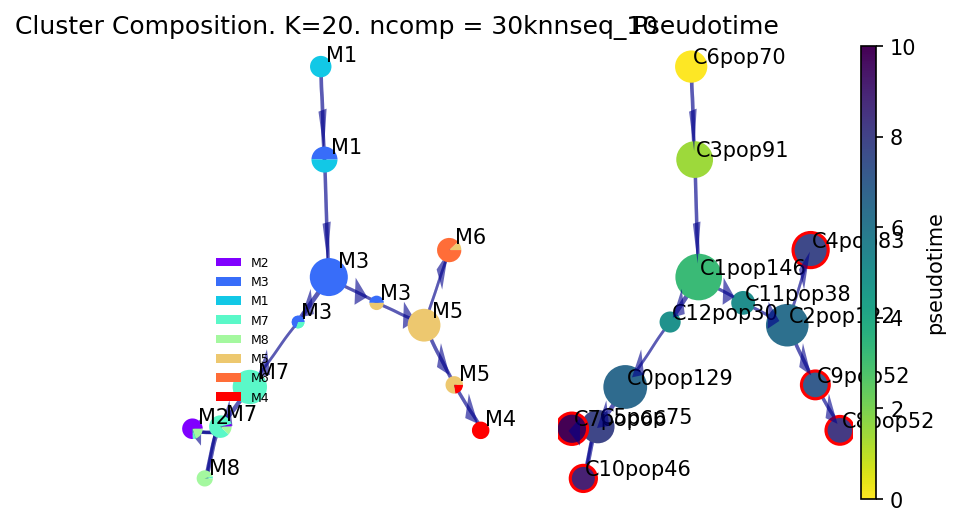

time elapsed 10.4 seconds


In [4]:
'''
# knn: number of nearest neighbors for the KNN-graph 
# clustergraph_pruning: typically 0-3, the number of standard deviations for clustergraph pruning. level of pruning applied to the clustergraph carried forward for pseudotime and lineage probability calculations. Larger means less pruning  
# true_label: list of annotations. if these are unavailable then leave as default None
# dist_std_local: local pruning on the singlecell graph used for clustering step, 1 is quite quite minimal level of pruning.  
# too_big_factor: default 0.3. Clusters that are bigger than 30% of the entire cell population will be re-clustered. If you only plan to do one iteration of VIA before visualizing TI, consider lowering this to 0.1-0.2.  
# preserve_disconnected: if you suspect disconnected trajectories, set this to False
# dataset = 'group': works for any dataset where the root is provided as a group ID in the true_label. e.g. if root = ['Day0'], then the root will be selected as a cluster which has root like properties and is largely made up of 'Day0' cells. 
            #If you wish to run a second finegrained iteration of VIA on a disconnected dataset, but uses the terminal clusters from the previous coarse run, then the dataset should be set as 'toy' and the true_labels formatted as "T1_M1" where Tx is the x'th component and My is the y'th cluster.
            # otherwise for disconnected datasets, you can just run a single iteration of VIA where you vary too_big_factor and other parameters to change granularity and set the dataset as '' or 'group' depending on the root_user type as [groupX, groupZ ...] or [cell indices...]  
            # dataset, can be left as default value '', but then the root must be a cell index corresponding to a best guess. 
# root_user =['M1']
# visual_cluster_graph_pruning: this impacts the level of pruning done to the clustergraph before visualization. Does not impact underlying computations  
# Max_visual_outgoing_edges: controls number of edges extending from each node
'''

v0 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn, cluster_graph_pruning_std=1, too_big_factor=0.3, root_user=root_user, preserve_disconnected=True, dataset='group',
             visual_cluster_graph_pruning=1, max_visual_outgoing_edges=2,
             random_seed=random_seed, piegraph_arrow_head_width=0.2,
             piegraph_edgeweight_scalingfactor=1.0)  
v0.run_VIA()


### VIA graph

To visualize the results of the Trajectory inference in various ways. Via offers various plotting functions.We first show the cluster-graph level trajectory abstraction consisting of two subplots colored by annotated (true_label) composition and by pseudotime

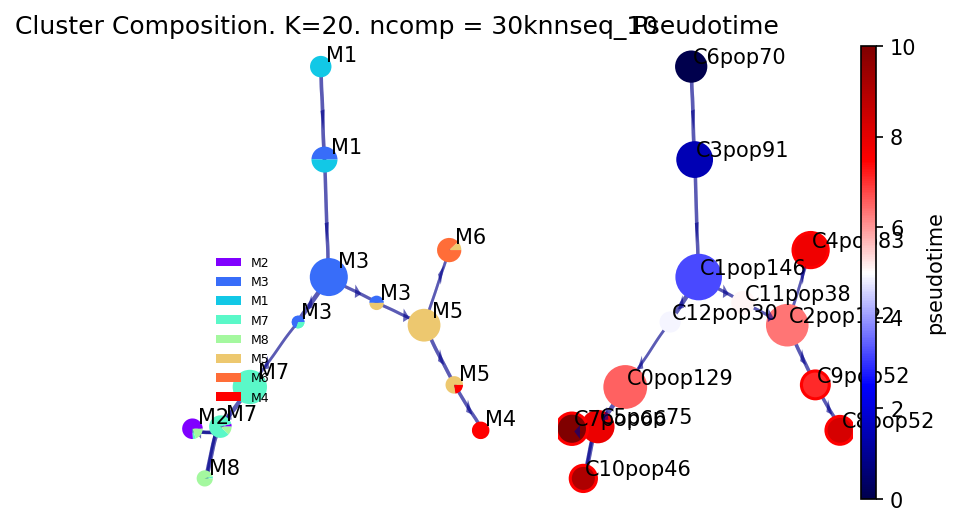

In [5]:
# draw the piechart clustergraph beside a clustergraph colored by the pseudotime ('pt') or gene expression ('gene').
# type_pt: 'pt' automatically takes the cluster level pseudotimes. 'gene' requires user to also pass gene_exp 
# gene_exp =''. In order to plot gene intensity, a list of cluster level gene/feature values should be provided
# cmap = None. Can be specified and influences the cmap of the pt/gene graph
# ax_text = True. Can set to false if you don't want the cluster and populations labels 
 
v0.draw_piechart_graph(type_data='pt', title='Toy multifurcation', cmap='seismic', ax_text=True, gene_exp='')




### Vector field
The vector field of trajectories is projected onto the embedding 

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


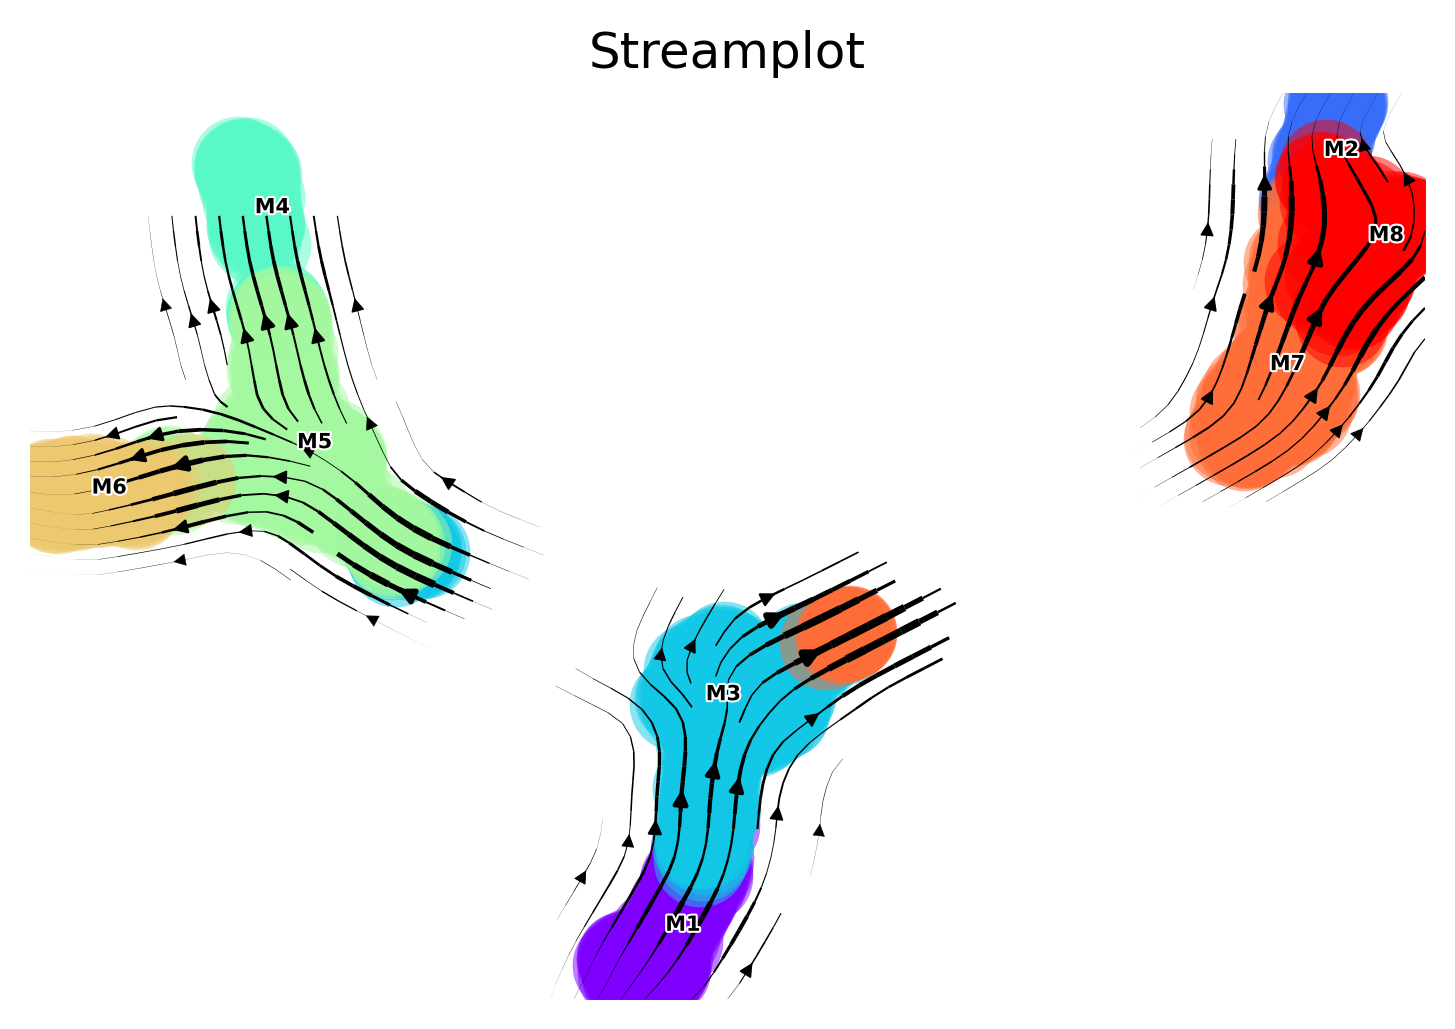

In [6]:
#default parameters:
# scatter_size=500
# scatter_alpha=0.5
# marker_edgewidth=0.1, outline of scatter points
# density_stream = 2, spacing between field lines
# smooth_transition=1,smoothing of transition matrix over neighbors of neighbors
# color_scheme = 'annotation', corresponds to true_labels provided. Can also be set to 'cluster' and 'time'
# add_outline_clusters=False

via_streamplot(v0, embedding)

### Overall trajectory 
Draw overall pseudotime and main trajectories on single cell embedding 

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

super cluster 4 is a super terminal with sub_terminal cluster 4
super cluster 7 is a super terminal with sub_terminal cluster 7
super cluster 8 is a super terminal with sub_terminal cluster 8
super cluster 9 is a super terminal with sub_terminal cluster 9
super cluster 10 is a super terminal with sub_terminal cluster 10


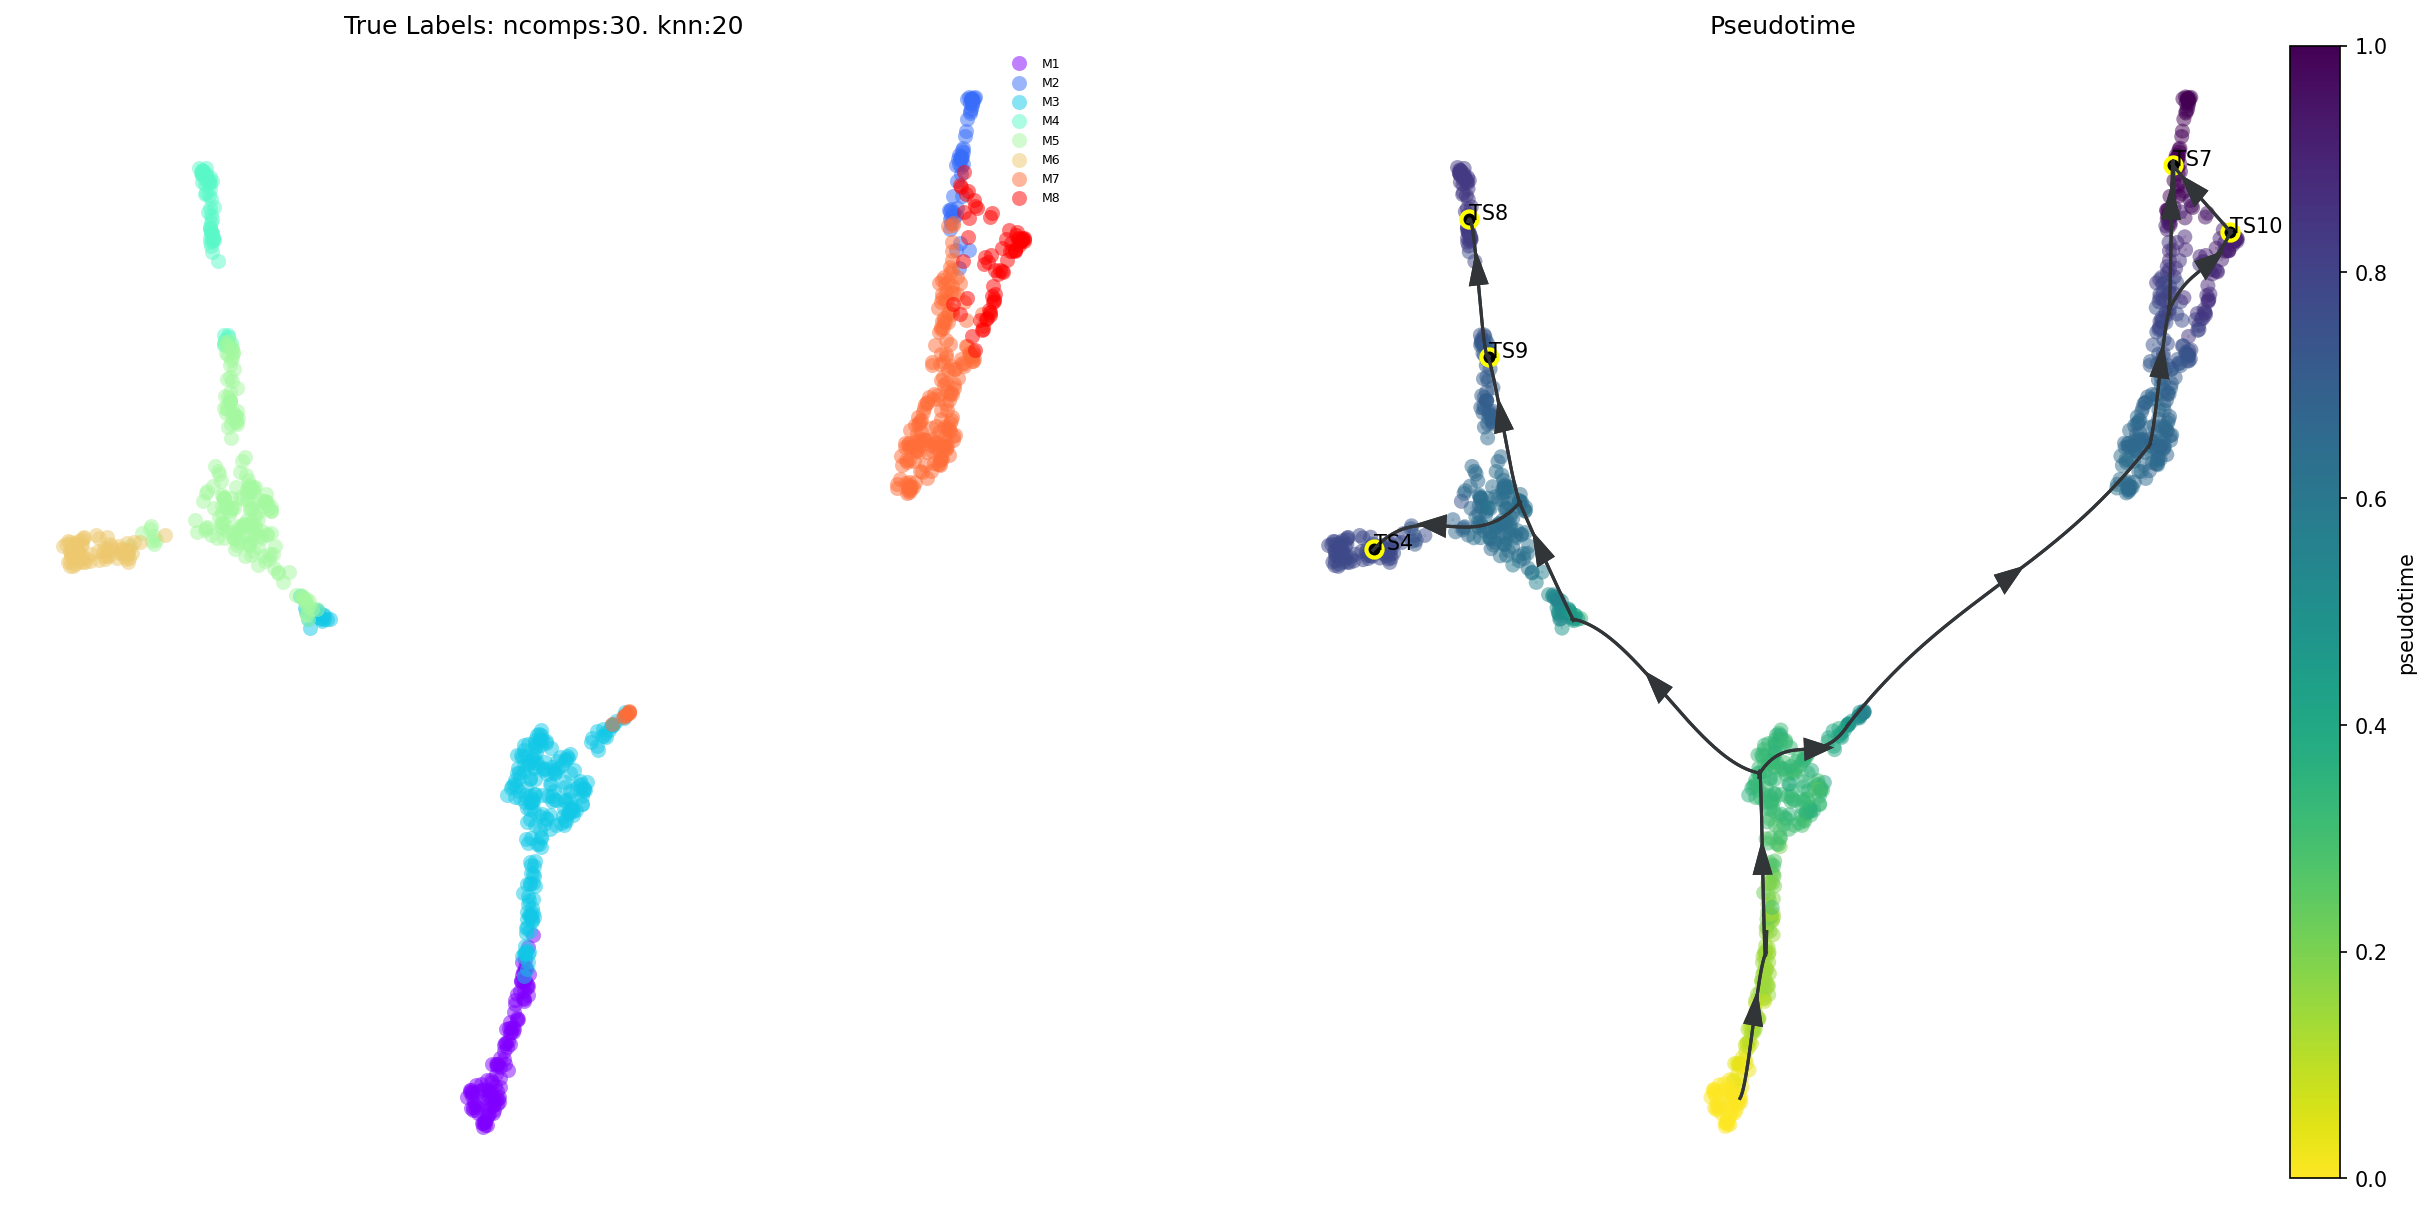

In [7]:
# draw overall pseudotime and main trajectories
draw_trajectory_gams(via_coarse=v0, via_fine=v0, embedding=embedding)
plt.show()

### Lineage probabilities
Plot the lineage probabilities for each lineage (associated with a terminal state)

Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 4 : [6, 3, 1, 11, 2, 4]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 7 : [6, 3, 1, 12, 0, 5, 7]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 8 : [6, 3, 1, 11, 2, 9, 8]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 9 : [6, 3, 1, 11, 2, 9]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 10 : [6, 3, 1, 12, 0, 5, 10]


2022-06-13 10:45:13.599904	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 1 along path: [6, 6, 6, 3, 1, 1, 1]
2022-06-13 10:45:13.679003	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 2 along path: [6, 6, 6, 3, 1, 11, 2, 2, 2]


2022-06-13 10:45:14.182748	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 3 along path: [6, 6, 6, 3, 3, 3, 3, 3, 3]
2022-06-13 10:45:14.292711	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 4 along path: [6, 6, 6, 3, 11, 2, 4, 4, 4]
2022-06-13 10:45:14.380626	Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster 5 along path: [6, 6, 6, 3, 12, 0, 5, 5]


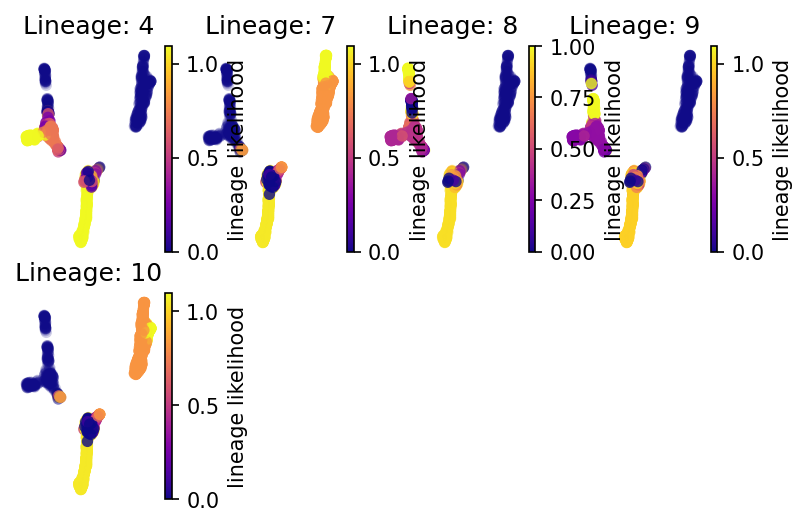

In [8]:
draw_sc_lineage_probability(via_coarse=v0, via_fine=v0,embedding=embedding)
plt.show()

###  Gene Dynamics
Plot the gene expression levels along each lineage for marker genes. Here we use dummy values for the Genes which are just the values of the initial PCs for illustrative purposes

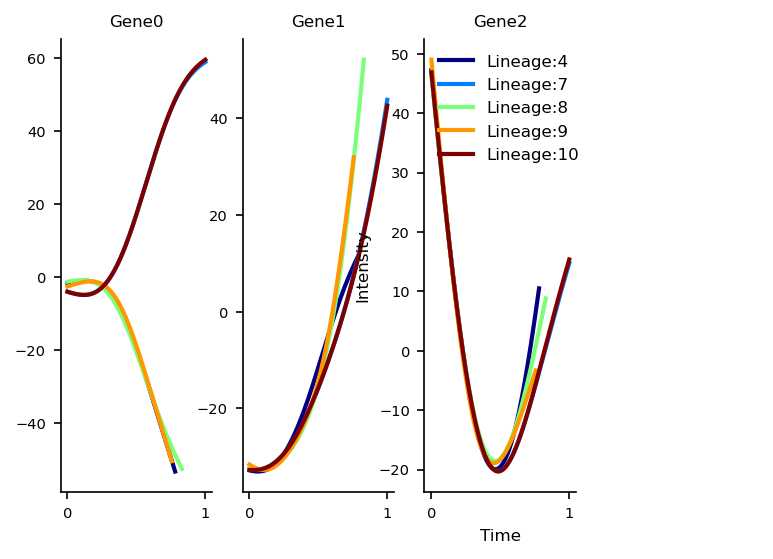

In [9]:
df_subset = pd.DataFrame(adata_counts.obsm['X_pca'][:, 0:3], columns=['Gene0', 'Gene1', 'Gene2'])
v0.get_gene_expression(gene_exp=df_subset, cmap='jet',linewidth=2, fontsize_=8, spline_order=4, n_splines=10) #default parameters shown here for retrieving gene expression


### Optional Second iteration
Sometimes it is desirable to construct a more finegrained clustergraph that uses the terminal states detected in a coarser iteration. 

The rest of the vignette covers how to link the fine and coarse grained iterations of Via. However, it is also possible to simply run a single iteration of Via and do so at various levels of granularity 

Mon Jun 13 10:45:40 2022 Correlation between VIA pseudotime and "temporal annotations 94.0 %
2022-06-13 10:45:40.068075	Running VIA over input data of 1000 (samples) x 30 (features)


2022-06-13 10:45:40.773549	Finished global pruning of 20-knn graph used for clustering. Kept 46.8 % of edges. 
2022-06-13 10:45:40.786834	Commencing community detection
2022-06-13 10:45:40.890914	Finished running Leiden algorithm. Found 48 clusters.
2022-06-13 10:45:40.891934	Found 3 clusters that are too big
2022-06-13 10:45:40.892190 Examining clusters that are above the too_big threshold
2022-06-13 10:45:40.892391	Cluster 1 contains 118>100 samples and is too big
2022-06-13 10:45:40.918834 Examining clusters that are above the too_big threshold
2022-06-13 10:45:40.919138	Cluster 0 contains 122>100 samples and is too big
2022-06-13 10:45:40.946500 Examining clusters that are above the too_big threshold
2022-06-13 10:45:40.946799	Cluster 2 contains 107>100 samples and is too big
2022-06-13 10:45:40.971283	Merging 36 very small clusters (<10)
2022-06-13 10:45:40.973029	Finished detecting communities. Found 27 communities
substituting labels in core_working
2022-06-13 10:45:40.973743	Ma

2022-06-13 10:45:41.621763	New root is 3
2022-06-13 10:45:41.636901	Computing lazy-teleporting expected hitting times


the sub terminal cluster that best captures the super terminal 4 is 1
the sub terminal cluster that best captures the super terminal 7 is 4
the sub terminal cluster that best captures the super terminal 8 is 7
the sub terminal cluster that best captures the super terminal 9 is 6
the sub terminal cluster that best captures the super terminal 10 is 8
2022-06-13 10:45:44.106805	Terminal clusters corresponding to unique lineages in this component are [1, 4, 7, 6, 8] 


2022-06-13 10:45:44.779901	From root 3,  the Terminal state 1 is reached 193 times.


2022-06-13 10:45:45.579623	From root 3,  the Terminal state 4 is reached 193 times.


2022-06-13 10:45:46.258165	From root 3,  the Terminal state 7 is reached 290 times.


2022-06-13 10:45:46.978206	From root 3,  the Terminal state 6 is reached 304 times.


2022-06-13 10:45:47.705533	From root 3,  the Terminal state 8 is reached 216 times.
2022-06-13 10:45:47.742066	Terminal clusters corresponding to unique lineages are [1, 4, 7, 6, 8] 
2022-06-13 10:45:47.742231	Begin projection of pseudotime and lineage likelihood


2022-06-13 10:45:48.002856	Graph has 1 connected components before pruning
2022-06-13 10:45:48.006890	Graph has 1 connected components before pruning n_nonz 2 2


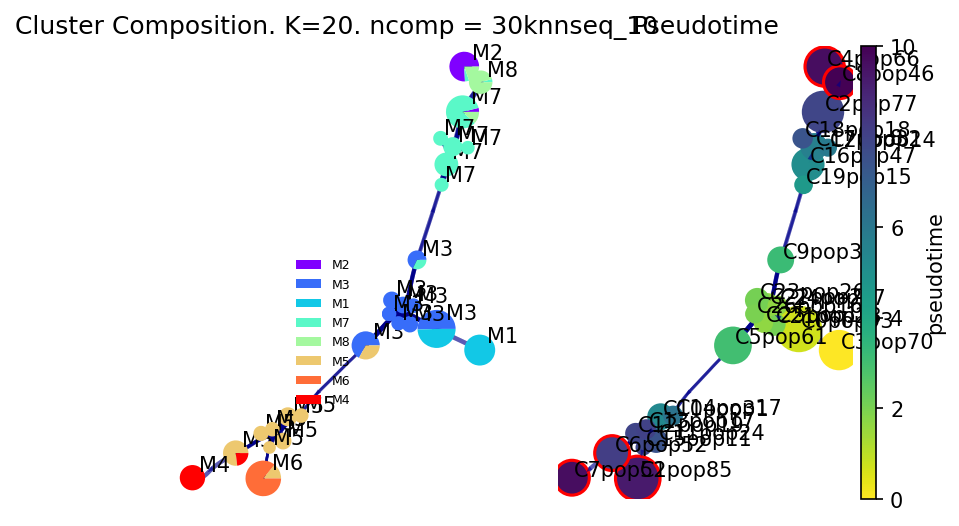

time elapsed 12.1 seconds
Mon Jun 13 10:45:52 2022 Correlation between VIA pseudotime and "temporal annotations 89.0 %


In [10]:

df_ids['pt'] = v0.single_cell_pt_markov
correlation = df_ids['pt'].corr(df_ids['true_time'])
print(time.ctime(),'Correlation between VIA pseudotime and "temporal annotations', round(correlation,2)*100,'%')

#the only additional step to link the two iterations is to pass on the v0 iteration to v1 by setting via_coarse = v0 when initializing VIA and setting is_coarse = False

v1 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn,too_big_factor=0.1,   cluster_graph_pruning_std=1, root_user=root_user, is_coarse=False,
             x_lazy=0.95, alpha_teleport=0.99, preserve_disconnected=True, dataset='group',    visual_cluster_graph_pruning=1, max_visual_outgoing_edges=2,random_seed=random_seed, via_coarse=v0)  

v1.run_VIA()
labels = v1.labels
df_ids['pt1'] = v1.single_cell_pt_markov
correlation = df_ids['pt1'].corr(df_ids['true_time'])
print(time.ctime(),'Correlation between VIA pseudotime and "temporal annotations', round(correlation,2)*100,'%')

Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 1 : [3, 0, 24, 23, 5, 14, 13, 1]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 4 : [3, 0, 24, 23, 9, 16, 18, 2, 4]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 7 : [3, 0, 24, 23, 5, 14, 13, 6, 7]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 6 : [3, 0, 24, 23, 5, 14, 13, 6]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 8 : [3, 0, 24, 23, 9, 16, 18, 2, 8]


2022-06-13 10:46:58.939936	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 1 along path: [3, 3, 3, 0, 5, 14, 1, 1, 1]
2022-06-13 10:46:58.986481	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 2 along path: [3, 3, 3, 0, 9, 17, 2, 2]
2022-06-13 10:46:59.070947	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 3 along path: [3]


2022-06-13 10:46:59.200612	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 4 along path: [3, 3, 3, 0, 9, 17, 2, 4, 4, 4]
2022-06-13 10:46:59.248232	Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster 5 along path: [3, 3, 3, 0, 5, 5, 5]


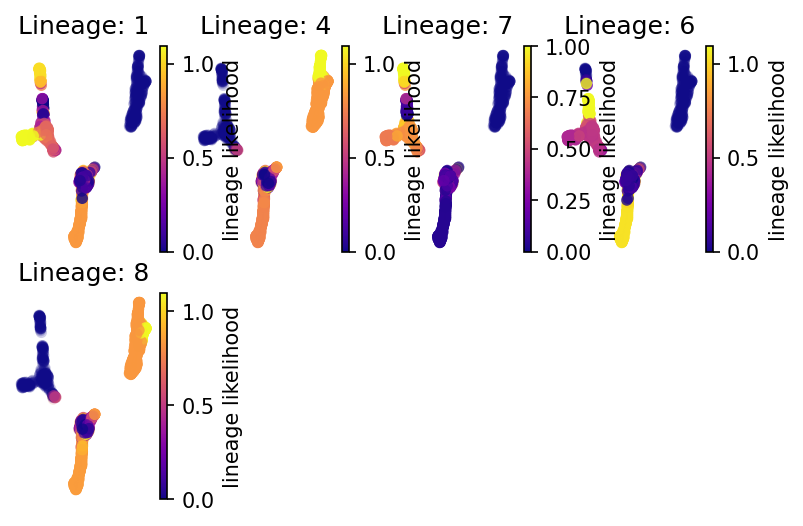

In [11]:
draw_sc_lineage_probability(v0,v1,embedding)
plt.show()

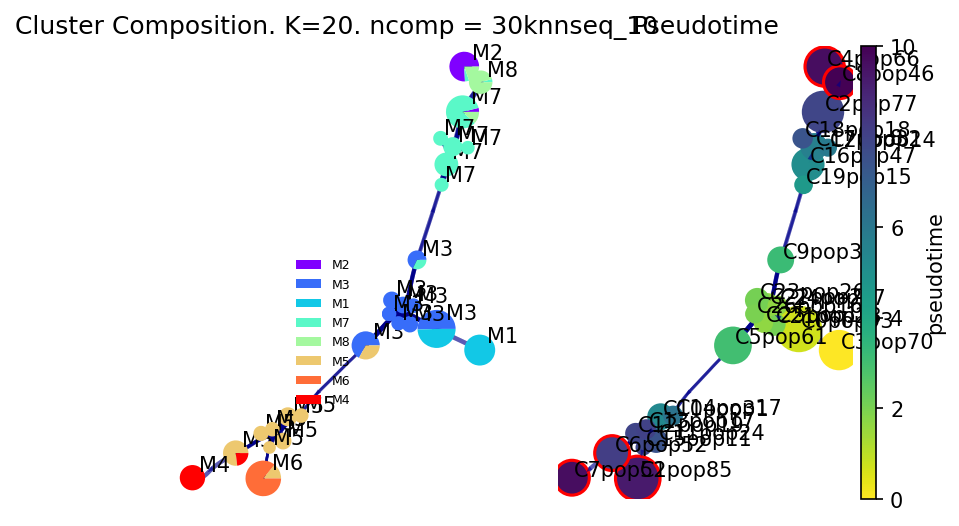

In [12]:
v1.draw_piechart_graph(type_data='pt', title='Toy multifurcation', cmap='viridis_r', ax_text=True, gene_exp='')

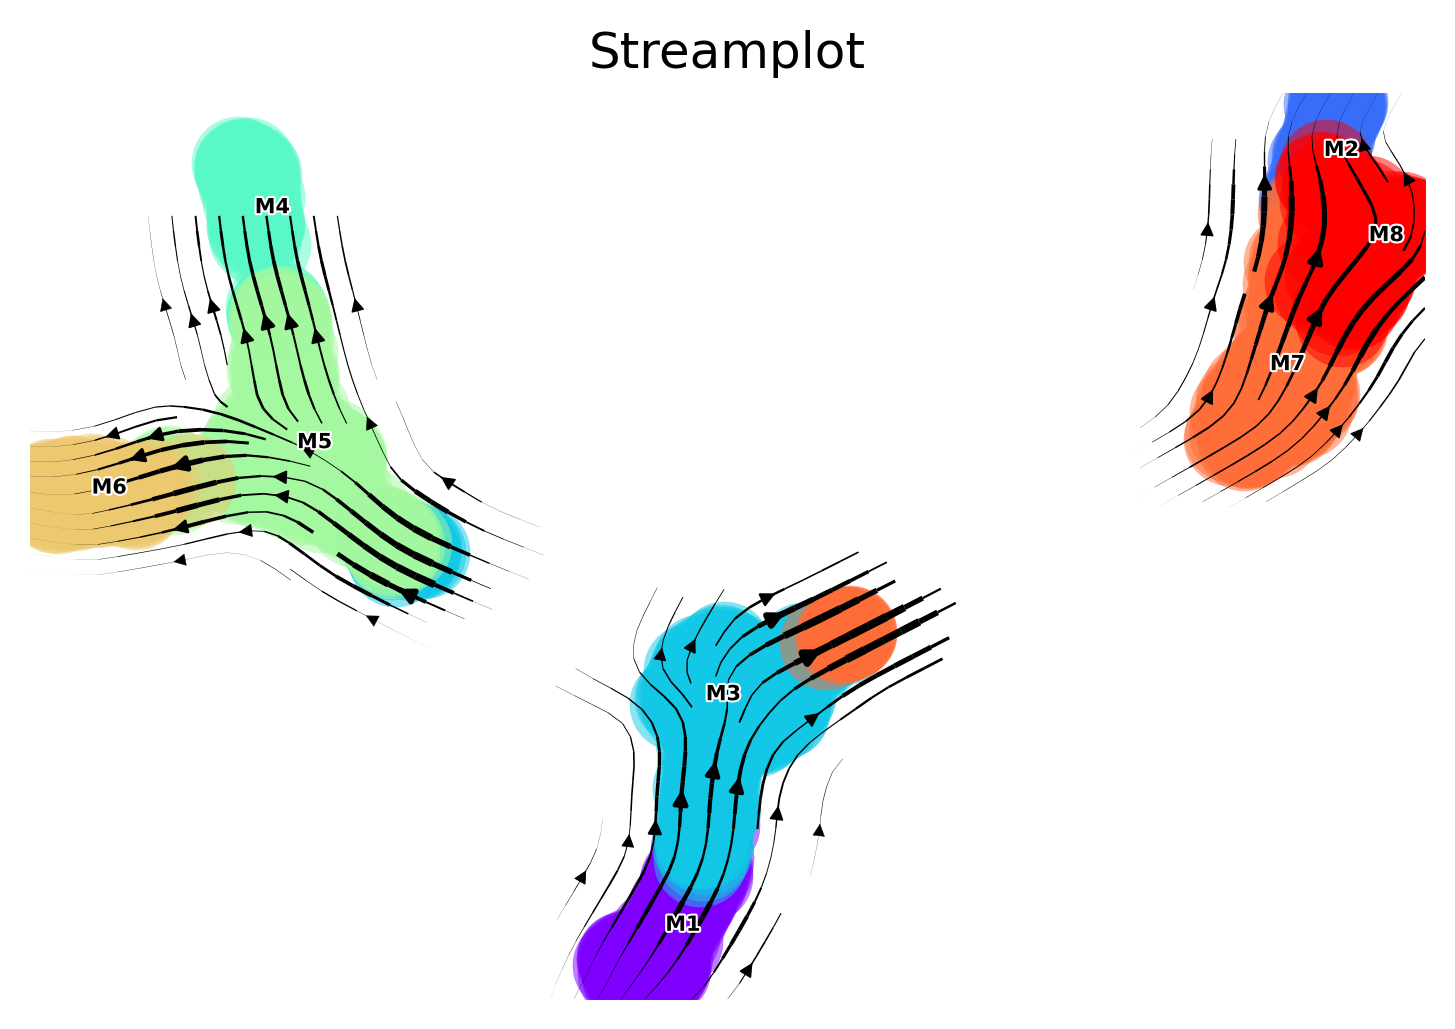

In [14]:
via_streamplot(v0, embedding)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 4 is a super terminal with sub_terminal cluster 1
super cluster 7 is a super terminal with sub_terminal cluster 4
super cluster 8 is a super terminal with sub_terminal cluster 7
super cluster 9 is a super terminal with sub_terminal cluster 6
super cluster 10 is a super terminal with sub_terminal cluster 8


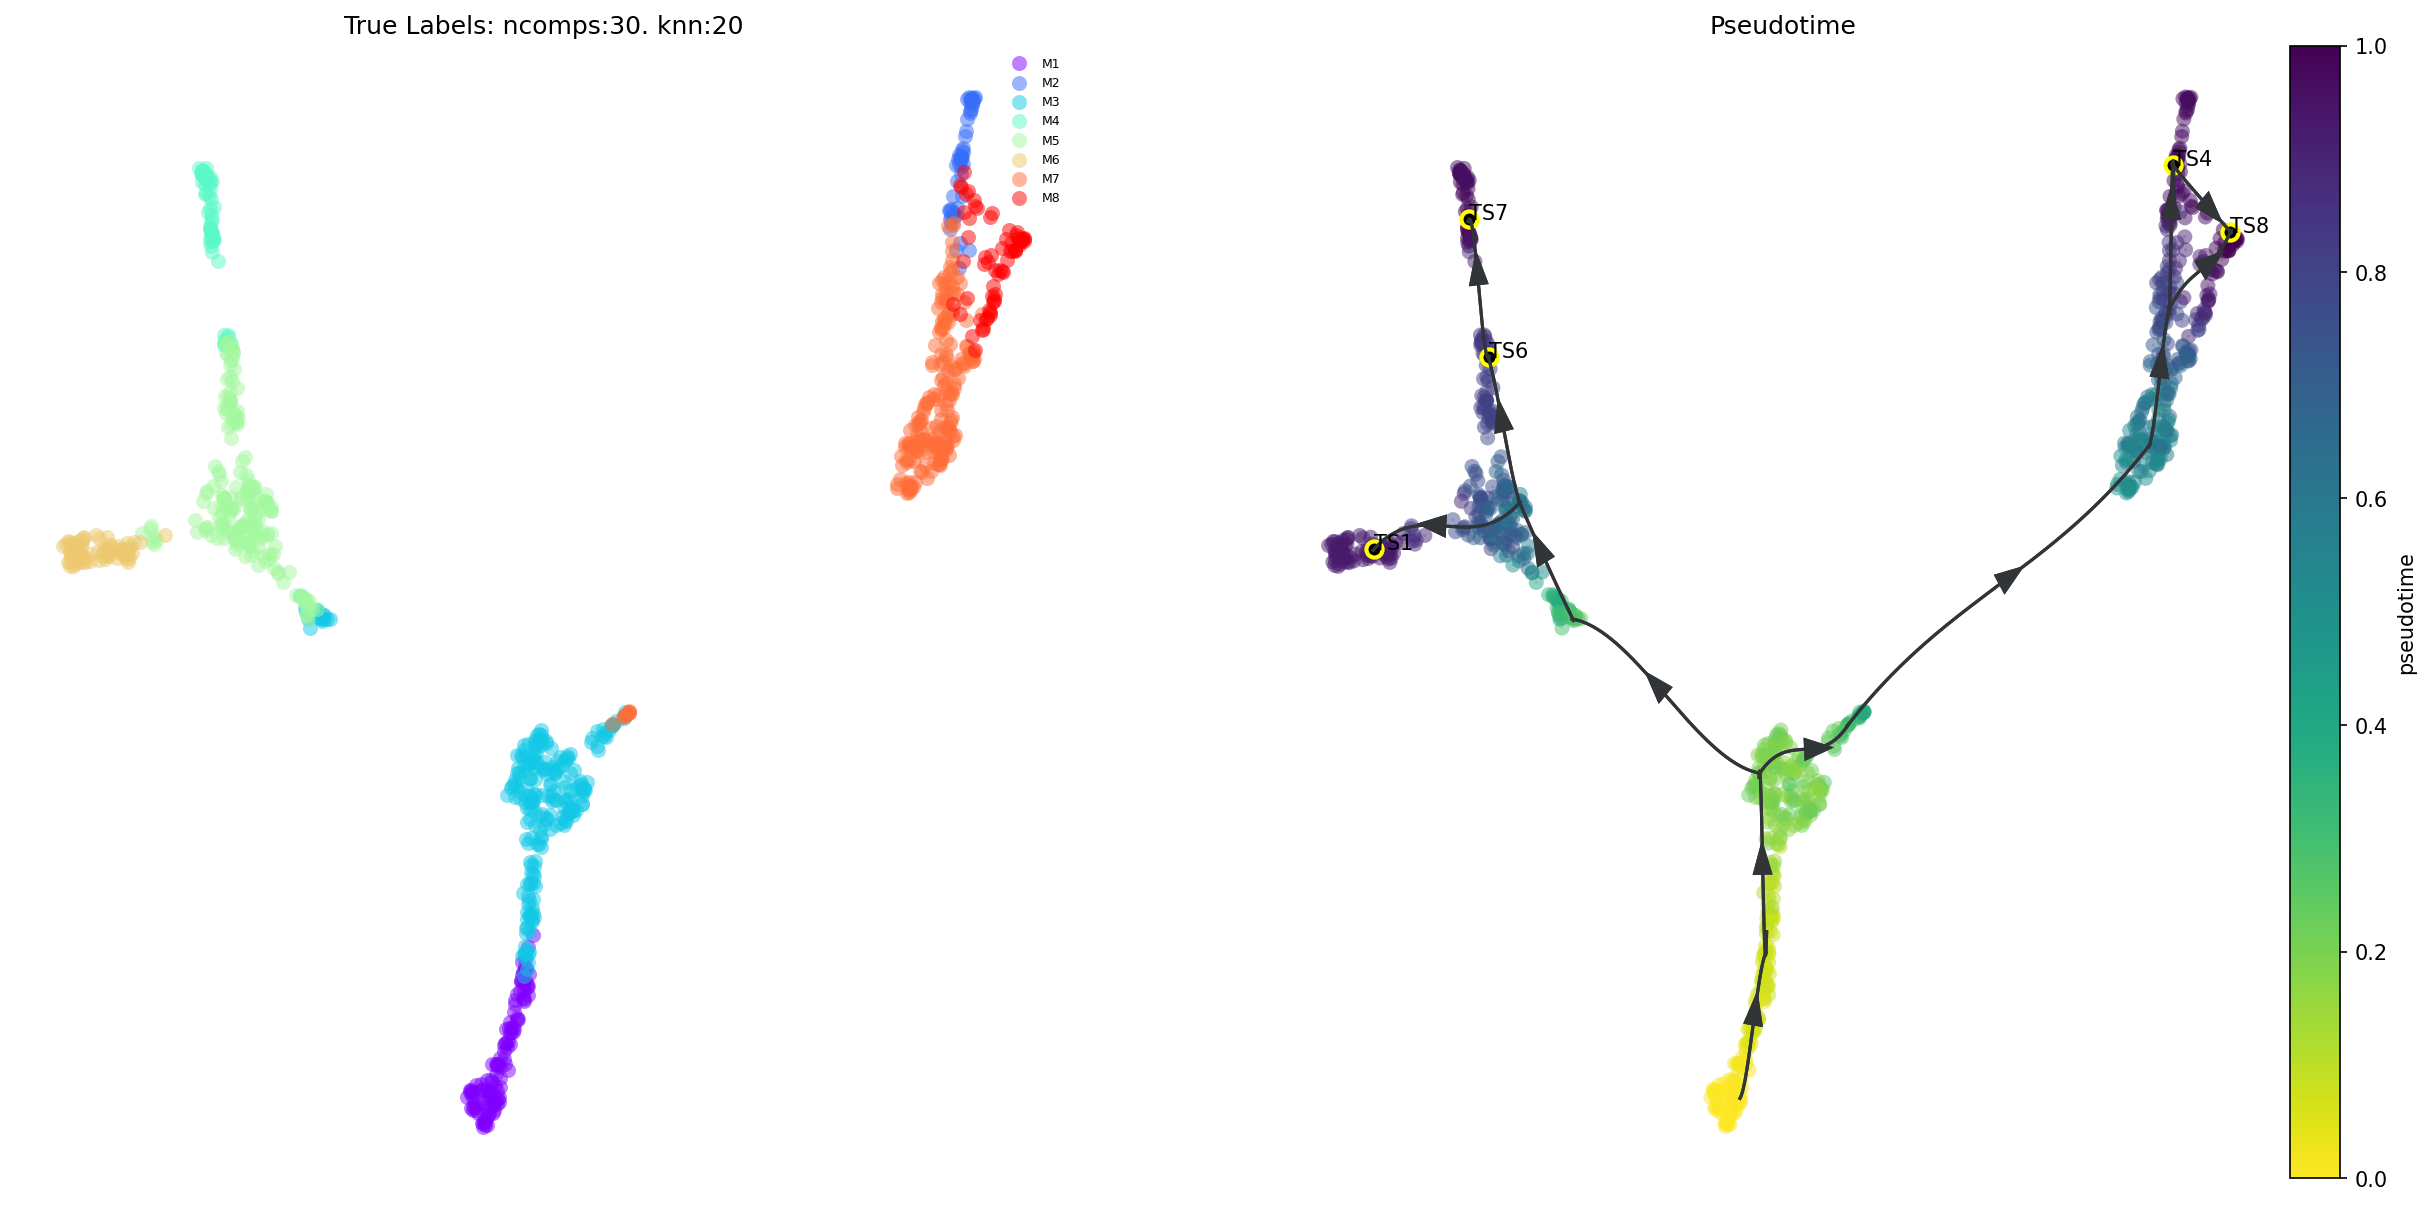

In [15]:
draw_trajectory_gams(via_coarse=v0, via_fine=v1, embedding=embedding)